# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) most strongly correlated with Consumption at t+3 (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sign-adjusted topics most strongly correlated with Consumption at t+3, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(4, 7):    # Varying factor order: 4, 5, 6
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11896
EM converged at iteration 61, llf=-11672, convergence criterion=9.9134e-07 < tolerance=1e-06
EM start iterations, llf=-11909
EM converged at iteration 61, llf=-11684, convergence criterion=9.8901e-07 < tolerance=1e-06
EM start iterations, llf=-11965
EM converged at iteration 60, llf=-11738, convergence criterion=9.8457e-07 < tolerance=1e-06
EM start iterations, llf=-11972
EM converged at iteration 60, llf=-11745, convergence criterion=9.8488e-07 < tolerance=1e-06
EM start iterations, llf=-12037
EM converged at iteration 60, llf=-11805, convergence criterion=9.9029e-07 < tolerance=1e-06
EM start iterations, llf=-12047
EM converged at iteration 60, llf=-11814, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-12103
EM converged at iteration 60, llf=-11873, convergence criterion=9.8562e-07 < tolerance=1e-06
EM start iterations, llf=-12103
EM converged at iteration 60, llf=-11873, convergence criterion=9.8562e-07 < tolerance=1e-06


EM start iterations, llf=-13623
EM converged at iteration 54, llf=-13466, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-13673
EM converged at iteration 51, llf=-13520, convergence criterion=9.845e-07 < tolerance=1e-06
EM start iterations, llf=-13682
EM converged at iteration 52, llf=-13529, convergence criterion=9.7158e-07 < tolerance=1e-06
EM start iterations, llf=-13736
EM converged at iteration 52, llf=-13580, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-13736
EM converged at iteration 52, llf=-13580, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-13747
EM converged at iteration 52, llf=-13593, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-13796
EM converged at iteration 51, llf=-13642, convergence criterion=9.6694e-07 < tolerance=1e-06
EM start iterations, llf=-13801
EM converged at iteration 51, llf=-13647, convergence criterion=9.8039e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15357
EM converged at iteration 52, llf=-15193, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-15357
EM converged at iteration 52, llf=-15193, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-15366
EM converged at iteration 52, llf=-15202, convergence criterion=9.8771e-07 < tolerance=1e-06
EM start iterations, llf=-15420
EM converged at iteration 52, llf=-15256, convergence criterion=9.7948e-07 < tolerance=1e-06
EM start iterations, llf=-15430
EM converged at iteration 52, llf=-15267, convergence criterion=9.821e-07 < tolerance=1e-06
EM start iterations, llf=-15481
EM converged at iteration 52, llf=-15316, convergence criterion=9.9335e-07 < tolerance=1e-06
EM start iterations, llf=-15489
EM converged at iteration 52, llf=-15324, convergence criterion=9.9222e-07 < tolerance=1e-06
EM start iterations, llf=-15537
EM converged at iteration 52, llf=-15372, convergence criterion=9.9793e-07 < tolerance=1e-06
E

EM start iterations, llf=-17079
EM converged at iteration 61, llf=-16893, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-17083
EM converged at iteration 61, llf=-16898, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-17137
EM converged at iteration 62, llf=-16951, convergence criterion=9.6933e-07 < tolerance=1e-06
EM start iterations, llf=-17144
EM converged at iteration 62, llf=-16958, convergence criterion=9.7024e-07 < tolerance=1e-06
EM start iterations, llf=-17201
EM converged at iteration 62, llf=-17015, convergence criterion=9.6903e-07 < tolerance=1e-06
EM start iterations, llf=-17201
EM converged at iteration 62, llf=-17015, convergence criterion=9.6903e-07 < tolerance=1e-06
EM start iterations, llf=-17210
EM converged at iteration 61, llf=-17023, convergence criterion=9.9659e-07 < tolerance=1e-06
EM start iterations, llf=-17262
EM converged at iteration 61, llf=-17075, convergence criterion=9.9385e-07 < tolerance=1e-06


EM start iterations, llf=-18617
EM converged at iteration 63, llf=-18417, convergence criterion=9.7406e-07 < tolerance=1e-06
EM start iterations, llf=-18674
EM converged at iteration 63, llf=-18472, convergence criterion=9.6958e-07 < tolerance=1e-06
EM start iterations, llf=-18674
EM converged at iteration 63, llf=-18472, convergence criterion=9.6958e-07 < tolerance=1e-06
EM start iterations, llf=-18679
EM converged at iteration 63, llf=-18478, convergence criterion=9.6935e-07 < tolerance=1e-06
EM start iterations, llf=-18732
EM converged at iteration 63, llf=-18530, convergence criterion=9.7178e-07 < tolerance=1e-06
EM start iterations, llf=-18738
EM converged at iteration 63, llf=-18536, convergence criterion=9.7202e-07 < tolerance=1e-06
EM start iterations, llf=-18795
EM converged at iteration 62, llf=-18592, convergence criterion=9.9975e-07 < tolerance=1e-06
EM start iterations, llf=-18802
EM converged at iteration 62, llf=-18599, convergence criterion=9.9947e-07 < tolerance=1e-06


EM start iterations, llf=-12456
EM converged at iteration 58, llf=-12211, convergence criterion=9.6852e-07 < tolerance=1e-06
EM start iterations, llf=-12445
EM converged at iteration 58, llf=-12194, convergence criterion=9.6723e-07 < tolerance=1e-06
EM start iterations, llf=-12503
EM converged at iteration 57, llf=-12268, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-12520
EM converged at iteration 57, llf=-12296, convergence criterion=9.9626e-07 < tolerance=1e-06
EM start iterations, llf=-12577
EM converged at iteration 58, llf=-12383, convergence criterion=9.854e-07 < tolerance=1e-06
EM start iterations, llf=-12577
EM converged at iteration 58, llf=-12380, convergence criterion=9.8664e-07 < tolerance=1e-06
EM start iterations, llf=-12595
EM converged at iteration 57, llf=-12409, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-12595
EM converged at iteration 57, llf=-12409, convergence criterion=9.8356e-07 < tolerance=1e-06
E

EM start iterations, llf=-14160
EM converged at iteration 52, llf=-14006, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-14200
EM converged at iteration 53, llf=-14044, convergence criterion=9.783e-07 < tolerance=1e-06
EM start iterations, llf=-14204
EM converged at iteration 53, llf=-14050, convergence criterion=9.6391e-07 < tolerance=1e-06
EM start iterations, llf=-14251
EM converged at iteration 51, llf=-14098, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-14251
EM converged at iteration 51, llf=-14098, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-14262
EM converged at iteration 51, llf=-14109, convergence criterion=9.8293e-07 < tolerance=1e-06
EM start iterations, llf=-14317
EM converged at iteration 51, llf=-14164, convergence criterion=9.8412e-07 < tolerance=1e-06
EM start iterations, llf=-14325
EM converged at iteration 51, llf=-14171, convergence criterion=9.8707e-07 < tolerance=1e-06
E

EM start iterations, llf=-15914
EM converged at iteration 51, llf=-15743, convergence criterion=9.6944e-07 < tolerance=1e-06
EM start iterations, llf=-15914
EM converged at iteration 51, llf=-15743, convergence criterion=9.6944e-07 < tolerance=1e-06
EM start iterations, llf=-15922
EM converged at iteration 51, llf=-15752, convergence criterion=9.7292e-07 < tolerance=1e-06
EM start iterations, llf=-15976
EM converged at iteration 51, llf=-15806, convergence criterion=9.7116e-07 < tolerance=1e-06
EM start iterations, llf=-15979
EM converged at iteration 51, llf=-15807, convergence criterion=9.7327e-07 < tolerance=1e-06
EM start iterations, llf=-16035
EM converged at iteration 51, llf=-15863, convergence criterion=9.7352e-07 < tolerance=1e-06
EM start iterations, llf=-16040
EM converged at iteration 51, llf=-15869, convergence criterion=9.6818e-07 < tolerance=1e-06
EM start iterations, llf=-16085
EM converged at iteration 51, llf=-15913, convergence criterion=9.7101e-07 < tolerance=1e-06


EM start iterations, llf=-17636
EM converged at iteration 60, llf=-17451, convergence criterion=9.7789e-07 < tolerance=1e-06
EM start iterations, llf=-17641
EM converged at iteration 60, llf=-17457, convergence criterion=9.777e-07 < tolerance=1e-06
EM start iterations, llf=-17694
EM converged at iteration 60, llf=-17508, convergence criterion=9.8234e-07 < tolerance=1e-06
EM start iterations, llf=-17703
EM converged at iteration 60, llf=-17517, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-17750
EM converged at iteration 60, llf=-17563, convergence criterion=9.771e-07 < tolerance=1e-06
EM start iterations, llf=-17750
EM converged at iteration 60, llf=-17563, convergence criterion=9.771e-07 < tolerance=1e-06
EM start iterations, llf=-17769
EM converged at iteration 60, llf=-17582, convergence criterion=9.7738e-07 < tolerance=1e-06
EM start iterations, llf=-17822
EM converged at iteration 60, llf=-17634, convergence criterion=9.7282e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-19164
EM converged at iteration 60, llf=-18957, convergence criterion=9.9435e-07 < tolerance=1e-06
EM start iterations, llf=-19212
EM converged at iteration 60, llf=-19005, convergence criterion=9.9093e-07 < tolerance=1e-06
EM start iterations, llf=-19212
EM converged at iteration 60, llf=-19005, convergence criterion=9.9093e-07 < tolerance=1e-06
EM start iterations, llf=-19219
EM converged at iteration 60, llf=-19013, convergence criterion=9.904e-07 < tolerance=1e-06
EM start iterations, llf=-19272
EM converged at iteration 60, llf=-19065, convergence criterion=9.8707e-07 < tolerance=1e-06
EM start iterations, llf=-19281
EM converged at iteration 60, llf=-19074, convergence criterion=9.8671e-07 < tolerance=1e-06
EM start iterations, llf=-19333
EM converged at iteration 60, llf=-19126, convergence criterion=9.7389e-07 < tolerance=1e-06
EM start iterations, llf=-19342
EM converged at iteration 60, llf=-19134, convergence criterion=9.7321e-07 < tolerance=1e-06
E

EM start iterations, llf=-12965
EM converged at iteration 57, llf=-12805, convergence criterion=9.6898e-07 < tolerance=1e-06
EM start iterations, llf=-12969
EM converged at iteration 57, llf=-12808, convergence criterion=9.6573e-07 < tolerance=1e-06
EM start iterations, llf=-13018
EM converged at iteration 56, llf=-12855, convergence criterion=9.8756e-07 < tolerance=1e-06
EM start iterations, llf=-13027
EM converged at iteration 56, llf=-12863, convergence criterion=9.8622e-07 < tolerance=1e-06
EM start iterations, llf=-13074
EM converged at iteration 53, llf=-12908, convergence criterion=9.8095e-07 < tolerance=1e-06
EM start iterations, llf=-13085
EM converged at iteration 53, llf=-12919, convergence criterion=9.8027e-07 < tolerance=1e-06
EM start iterations, llf=-13142
EM converged at iteration 52, llf=-12982, convergence criterion=9.9722e-07 < tolerance=1e-06
EM start iterations, llf=-13142
EM converged at iteration 52, llf=-12982, convergence criterion=9.9722e-07 < tolerance=1e-06


EM start iterations, llf=-14693
EM converged at iteration 51, llf=-14535, convergence criterion=9.7491e-07 < tolerance=1e-06
EM start iterations, llf=-14747
EM converged at iteration 50, llf=-14590, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-14754
EM converged at iteration 50, llf=-14596, convergence criterion=9.9889e-07 < tolerance=1e-06
EM start iterations, llf=-14809
EM converged at iteration 50, llf=-14650, convergence criterion=9.9587e-07 < tolerance=1e-06
EM start iterations, llf=-14809
EM converged at iteration 50, llf=-14650, convergence criterion=9.9587e-07 < tolerance=1e-06
EM start iterations, llf=-14817
EM converged at iteration 50, llf=-14659, convergence criterion=9.963e-07 < tolerance=1e-06
EM start iterations, llf=-14873
EM converged at iteration 51, llf=-14715, convergence criterion=9.667e-07 < tolerance=1e-06
EM start iterations, llf=-14882
EM converged at iteration 51, llf=-14724, convergence criterion=9.7239e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16467
EM converged at iteration 50, llf=-16295, convergence criterion=9.9481e-07 < tolerance=1e-06
EM start iterations, llf=-16467
EM converged at iteration 50, llf=-16295, convergence criterion=9.9481e-07 < tolerance=1e-06
EM start iterations, llf=-16477
EM converged at iteration 50, llf=-16304, convergence criterion=9.9791e-07 < tolerance=1e-06
EM start iterations, llf=-16528
EM converged at iteration 50, llf=-16355, convergence criterion=9.8948e-07 < tolerance=1e-06
EM start iterations, llf=-16537
EM converged at iteration 50, llf=-16364, convergence criterion=9.8555e-07 < tolerance=1e-06
EM start iterations, llf=-16587
EM converged at iteration 50, llf=-16413, convergence criterion=9.7947e-07 < tolerance=1e-06
EM start iterations, llf=-16594
EM converged at iteration 50, llf=-16420, convergence criterion=9.8343e-07 < tolerance=1e-06
EM start iterations, llf=-16647
EM converged at iteration 50, llf=-16473, convergence criterion=9.8232e-07 < tolerance=1e-06


EM start iterations, llf=-18185
EM converged at iteration 60, llf=-17992, convergence criterion=9.7914e-07 < tolerance=1e-06
EM start iterations, llf=-18191
EM converged at iteration 60, llf=-17998, convergence criterion=9.7854e-07 < tolerance=1e-06
EM start iterations, llf=-18244
EM converged at iteration 60, llf=-18050, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-18252
EM converged at iteration 60, llf=-18058, convergence criterion=9.9538e-07 < tolerance=1e-06
EM start iterations, llf=-18308
EM converged at iteration 60, llf=-18114, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-18308
EM converged at iteration 60, llf=-18114, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-18313
EM converged at iteration 60, llf=-18118, convergence criterion=9.9423e-07 < tolerance=1e-06
EM start iterations, llf=-18366
EM converged at iteration 60, llf=-18171, convergence criterion=9.913e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-19433
EM converged at iteration 61, llf=-19220, convergence criterion=9.7769e-07 < tolerance=1e-06
EM start iterations, llf=-19488
EM converged at iteration 61, llf=-19275, convergence criterion=9.766e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 6 estimated in 1:51:09.866732.
EM start iterations, llf=-11412
EM iteration 100, llf=-11278, convergence criterion=1.048e-06
EM converged at iteration 103, llf=-11278, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-11424
EM iteration 100, llf=-11290, convergence criterion=1.0423e-06
EM converged at iteration 103, llf=-11290, convergence criterion=9.81e-07 < tolerance=1e-06
EM start iterations, llf=-11478
EM iteration 100, llf=-11344, convergence criterion=1.0254e-06
EM converged at iteration 102, llf=-11344, convergence criterion=9.8461e-07 < tolerance=1e-06
EM start iterations, llf=-11486
EM iteration 100, llf=-11351, convergence criterion=1.0103e-06
EM converged at ite

EM start iterations, llf=-12712
EM converged at iteration 77, llf=-12566, convergence criterion=9.8017e-07 < tolerance=1e-06
EM start iterations, llf=-12712
EM converged at iteration 77, llf=-12566, convergence criterion=9.8017e-07 < tolerance=1e-06
EM start iterations, llf=-12726
EM converged at iteration 77, llf=-12579, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-12771
EM converged at iteration 78, llf=-12626, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-12784
EM converged at iteration 79, llf=-12640, convergence criterion=9.8488e-07 < tolerance=1e-06
EM start iterations, llf=-12830
EM converged at iteration 80, llf=-12687, convergence criterion=9.843e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM converged at iteration 80, llf=-12728, convergence criterion=9.9487e-07 < tolerance=1e-06
EM start iterations, llf=-12919
EM converged at iteration 80, llf=-12776, convergence criterion=9.899e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14327
EM converged at iteration 84, llf=-14185, convergence criterion=9.8235e-07 < tolerance=1e-06
EM start iterations, llf=-14334
EM converged at iteration 83, llf=-14191, convergence criterion=9.9798e-07 < tolerance=1e-06
EM start iterations, llf=-14396
EM converged at iteration 84, llf=-14252, convergence criterion=9.8557e-07 < tolerance=1e-06
EM start iterations, llf=-14404
EM converged at iteration 84, llf=-14261, convergence criterion=9.984e-07 < tolerance=1e-06
EM start iterations, llf=-14454
EM converged at iteration 81, llf=-14308, convergence criterion=9.8349e-07 < tolerance=1e-06
EM start iterations, llf=-14454
EM converged at iteration 81, llf=-14308, convergence criterion=9.8349e-07 < tolerance=1e-06
EM start iterations, llf=-14458
EM converged at iteration 82, llf=-14314, convergence criterion=9.9539e-07 < tolerance=1e-06
EM start iterations, llf=-14505
EM converged at iteration 83, llf=-14362, convergence criterion=9.9975e-07 < tolerance=1e-06
E

EM start iterations, llf=-16002
EM converged at iteration 78, llf=-15852, convergence criterion=9.9882e-07 < tolerance=1e-06
EM start iterations, llf=-16054
EM converged at iteration 78, llf=-15903, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-16054
EM converged at iteration 78, llf=-15903, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-16052
EM converged at iteration 79, llf=-15902, convergence criterion=9.864e-07 < tolerance=1e-06
EM start iterations, llf=-16099
EM converged at iteration 79, llf=-15950, convergence criterion=9.9453e-07 < tolerance=1e-06
EM start iterations, llf=-16107
EM converged at iteration 79, llf=-15957, convergence criterion=9.8254e-07 < tolerance=1e-06
EM start iterations, llf=-16162
EM converged at iteration 78, llf=-16011, convergence criterion=9.8749e-07 < tolerance=1e-06
EM start iterations, llf=-16170
EM converged at iteration 77, llf=-16019, convergence criterion=9.8851e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-17658
EM converged at iteration 72, llf=-17501, convergence criterion=9.9348e-07 < tolerance=1e-06
EM start iterations, llf=-17713
EM converged at iteration 72, llf=-17556, convergence criterion=9.848e-07 < tolerance=1e-06
EM start iterations, llf=-17722
EM converged at iteration 73, llf=-17566, convergence criterion=9.7687e-07 < tolerance=1e-06
EM start iterations, llf=-17765
EM converged at iteration 72, llf=-17610, convergence criterion=9.9254e-07 < tolerance=1e-06
EM start iterations, llf=-17781
EM converged at iteration 72, llf=-17622, convergence criterion=9.7811e-07 < tolerance=1e-06
EM start iterations, llf=-17627
EM converged at iteration 72, llf=-17475, convergence criterion=9.7689e-07 < tolerance=1e-06
EM start iterations, llf=-17627
EM converged at iteration 72, llf=-17475, convergence criterion=9.7689e-07 < tolerance=1e-06
EM start iterations, llf=-17632
EM converged at iteration 71, llf=-17480, convergence criterion=9.9804e-07 < tolerance=1e-06
E

EM converged at iteration 84, llf=-11518, convergence criterion=9.8852e-07 < tolerance=1e-06
EM start iterations, llf=-11717
EM converged at iteration 84, llf=-11569, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-11721
EM converged at iteration 84, llf=-11575, convergence criterion=9.9032e-07 < tolerance=1e-06
EM start iterations, llf=-11765
EM converged at iteration 91, llf=-11621, convergence criterion=9.8827e-07 < tolerance=1e-06
EM start iterations, llf=-11765
EM converged at iteration 91, llf=-11621, convergence criterion=9.8827e-07 < tolerance=1e-06
EM start iterations, llf=-11775
EM converged at iteration 90, llf=-11632, convergence criterion=9.9746e-07 < tolerance=1e-06
EM start iterations, llf=-11821
EM converged at iteration 91, llf=-11680, convergence criterion=9.855e-07 < tolerance=1e-06
EM start iterations, llf=-11836
EM converged at iteration 93, llf=-11692, convergence criterion=9.9254e-07 < tolerance=1e-06
EM start iterations, llf=-11873
E

EM start iterations, llf=-13234
EM converged at iteration 81, llf=-13087, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-13234
EM converged at iteration 81, llf=-13087, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-13242
EM converged at iteration 83, llf=-13096, convergence criterion=9.9637e-07 < tolerance=1e-06
EM start iterations, llf=-13292
EM converged at iteration 84, llf=-13143, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-13304
EM converged at iteration 83, llf=-13156, convergence criterion=9.8925e-07 < tolerance=1e-06
EM start iterations, llf=-13350
EM converged at iteration 82, llf=-13201, convergence criterion=9.9034e-07 < tolerance=1e-06
EM start iterations, llf=-13357
EM converged at iteration 82, llf=-13209, convergence criterion=9.8138e-07 < tolerance=1e-06
EM start iterations, llf=-13404
EM converged at iteration 82, llf=-13253, convergence criterion=9.9219e-07 < tolerance=1e-06


EM start iterations, llf=-14850
EM converged at iteration 73, llf=-14703, convergence criterion=9.8185e-07 < tolerance=1e-06
EM start iterations, llf=-14859
EM converged at iteration 73, llf=-14712, convergence criterion=9.7751e-07 < tolerance=1e-06
EM start iterations, llf=-14915
EM converged at iteration 73, llf=-14768, convergence criterion=9.869e-07 < tolerance=1e-06
EM start iterations, llf=-14924
EM converged at iteration 73, llf=-14778, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-14979
EM converged at iteration 73, llf=-14833, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-14979
EM converged at iteration 73, llf=-14833, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-14991
EM converged at iteration 73, llf=-14845, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-15042
EM converged at iteration 73, llf=-14896, convergence criterion=9.8034e-07 < tolerance=1e-06
E

EM start iterations, llf=-16525
EM converged at iteration 85, llf=-16372, convergence criterion=9.9389e-07 < tolerance=1e-06
EM start iterations, llf=-16575
EM converged at iteration 84, llf=-16421, convergence criterion=9.9913e-07 < tolerance=1e-06
EM start iterations, llf=-16575
EM converged at iteration 84, llf=-16421, convergence criterion=9.9913e-07 < tolerance=1e-06
EM start iterations, llf=-16584
EM converged at iteration 84, llf=-16430, convergence criterion=9.8734e-07 < tolerance=1e-06
EM start iterations, llf=-16635
EM converged at iteration 85, llf=-16481, convergence criterion=9.8428e-07 < tolerance=1e-06
EM start iterations, llf=-16640
EM converged at iteration 85, llf=-16485, convergence criterion=9.8304e-07 < tolerance=1e-06
EM start iterations, llf=-16691
EM converged at iteration 85, llf=-16535, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-16698
EM converged at iteration 85, llf=-16543, convergence criterion=9.8985e-07 < tolerance=1e-06


EM start iterations, llf=-17995
EM converged at iteration 80, llf=-17835, convergence criterion=9.966e-07 < tolerance=1e-06
EM start iterations, llf=-18050
EM converged at iteration 81, llf=-17891, convergence criterion=9.9342e-07 < tolerance=1e-06
EM start iterations, llf=-18055
EM converged at iteration 80, llf=-17897, convergence criterion=9.9964e-07 < tolerance=1e-06
EM start iterations, llf=-18104
EM converged at iteration 81, llf=-17946, convergence criterion=9.8312e-07 < tolerance=1e-06
EM start iterations, llf=-18118
EM converged at iteration 80, llf=-17959, convergence criterion=9.9665e-07 < tolerance=1e-06
EM start iterations, llf=-18164
EM converged at iteration 81, llf=-18004, convergence criterion=9.8324e-07 < tolerance=1e-06
EM start iterations, llf=-18164
EM converged at iteration 81, llf=-18004, convergence criterion=9.8324e-07 < tolerance=1e-06
EM start iterations, llf=-18173
EM converged at iteration 81, llf=-18014, convergence criterion=9.7926e-07 < tolerance=1e-06
E

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:1954: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('Global.1', 'Global.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


EM start iterations, llf=-12075
EM converged at iteration 76, llf=-11871, convergence criterion=9.9586e-07 < tolerance=1e-06


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:1954: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('Global.1', 'Global.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


EM start iterations, llf=-12077
EM converged at iteration 76, llf=-11877, convergence criterion=9.9071e-07 < tolerance=1e-06
EM start iterations, llf=-12025
EM converged at iteration 74, llf=-11886, convergence criterion=9.9878e-07 < tolerance=1e-06
EM start iterations, llf=-12025
EM converged at iteration 74, llf=-11886, convergence criterion=9.9878e-07 < tolerance=1e-06
EM start iterations, llf=-12020
EM converged at iteration 75, llf=-11878, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-12082
EM converged at iteration 70, llf=-11937, convergence criterion=9.7557e-07 < tolerance=1e-06
EM start iterations, llf=-12079
EM converged at iteration 73, llf=-11934, convergence criterion=9.8575e-07 < tolerance=1e-06
EM start iterations, llf=-12137
EM converged at iteration 81, llf=-11982, convergence criterion=9.8493e-07 < tolerance=1e-06


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:1954: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('Global.1', 'Global.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


EM start iterations, llf=-12219
EM converged at iteration 71, llf=-11972, convergence criterion=9.874e-07 < tolerance=1e-06
EM start iterations, llf=-12165
EM converged at iteration 76, llf=-12007, convergence criterion=9.8958e-07 < tolerance=1e-06
EM start iterations, llf=-12165
EM converged at iteration 76, llf=-12007, convergence criterion=9.8958e-07 < tolerance=1e-06
EM start iterations, llf=-12167
EM converged at iteration 76, llf=-12013, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-12229
EM converged at iteration 76, llf=-12070, convergence criterion=9.9777e-07 < tolerance=1e-06
EM start iterations, llf=-12239
EM converged at iteration 83, llf=-12087, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-12302
EM converged at iteration 84, llf=-12151, convergence criterion=9.8645e-07 < tolerance=1e-06
EM start iterations, llf=-12320
EM converged at iteration 84, llf=-12165, convergence criterion=9.9297e-07 < tolerance=1e-06
E

EM start iterations, llf=-13750
EM converged at iteration 71, llf=-13600, convergence criterion=9.7989e-07 < tolerance=1e-06
EM start iterations, llf=-13798
EM converged at iteration 70, llf=-13647, convergence criterion=9.8837e-07 < tolerance=1e-06
EM start iterations, llf=-13808
EM converged at iteration 71, llf=-13657, convergence criterion=9.74e-07 < tolerance=1e-06
EM start iterations, llf=-13843
EM converged at iteration 72, llf=-13695, convergence criterion=9.7712e-07 < tolerance=1e-06
EM start iterations, llf=-13868
EM converged at iteration 71, llf=-13718, convergence criterion=9.9192e-07 < tolerance=1e-06
EM start iterations, llf=-13912
EM converged at iteration 71, llf=-13762, convergence criterion=9.9409e-07 < tolerance=1e-06
EM start iterations, llf=-13912
EM converged at iteration 71, llf=-13762, convergence criterion=9.9409e-07 < tolerance=1e-06
EM start iterations, llf=-13916
EM converged at iteration 71, llf=-13766, convergence criterion=9.9172e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15460
EM converged at iteration 77, llf=-15311, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-15466
EM converged at iteration 77, llf=-15317, convergence criterion=9.9781e-07 < tolerance=1e-06
EM start iterations, llf=-15514
EM converged at iteration 77, llf=-15363, convergence criterion=9.959e-07 < tolerance=1e-06
EM start iterations, llf=-15514
EM converged at iteration 77, llf=-15363, convergence criterion=9.959e-07 < tolerance=1e-06
EM start iterations, llf=-15522
EM converged at iteration 78, llf=-15373, convergence criterion=9.9465e-07 < tolerance=1e-06
EM start iterations, llf=-15574
EM converged at iteration 78, llf=-15424, convergence criterion=9.8702e-07 < tolerance=1e-06
EM start iterations, llf=-15576
EM converged at iteration 78, llf=-15427, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-15631
EM converged at iteration 79, llf=-15481, convergence criterion=9.8886e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17106
EM converged at iteration 84, llf=-16952, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-17118
EM converged at iteration 85, llf=-16962, convergence criterion=9.8102e-07 < tolerance=1e-06
EM start iterations, llf=-17166
EM converged at iteration 85, llf=-17010, convergence criterion=9.908e-07 < tolerance=1e-06
EM start iterations, llf=-17174
EM converged at iteration 85, llf=-17019, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-17234
EM converged at iteration 86, llf=-17077, convergence criterion=9.8458e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM converged at iteration 85, llf=-17083, convergence criterion=9.9569e-07 < tolerance=1e-06
EM start iterations, llf=-17290
EM converged at iteration 86, llf=-17133, convergence criterion=9.8544e-07 < tolerance=1e-06
EM start iterations, llf=-17290
EM converged at iteration 86, llf=-17133, convergence criterion=9.8544e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18579
EM converged at iteration 78, llf=-18413, convergence criterion=9.8704e-07 < tolerance=1e-06
EM start iterations, llf=-18633
EM converged at iteration 79, llf=-18467, convergence criterion=9.9475e-07 < tolerance=1e-06
EM start iterations, llf=-18640
EM converged at iteration 79, llf=-18473, convergence criterion=9.9798e-07 < tolerance=1e-06
EM start iterations, llf=-18686
EM converged at iteration 79, llf=-18520, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-18686
EM converged at iteration 79, llf=-18520, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-18406
EM converged at iteration 81, llf=-18248, convergence criterion=9.8203e-07 < tolerance=1e-06
EM start iterations, llf=-18461
EM converged at iteration 80, llf=-18304, convergence criterion=9.8695e-07 < tolerance=1e-06
EM start iterations, llf=-18471
EM converged at iteration 80, llf=-18315, convergence criterion=9.8769e-07 < tolerance=1e-06


EM start iterations, llf=-12150
EM converged at iteration 93, llf=-12003, convergence criterion=9.957e-07 < tolerance=1e-06
EM start iterations, llf=-12156
EM converged at iteration 94, llf=-12011, convergence criterion=9.9908e-07 < tolerance=1e-06
EM start iterations, llf=-12185
EM converged at iteration 90, llf=-12042, convergence criterion=9.808e-07 < tolerance=1e-06
EM start iterations, llf=-12191
EM converged at iteration 91, llf=-12049, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations, llf=-12246
EM converged at iteration 91, llf=-12102, convergence criterion=9.9796e-07 < tolerance=1e-06
EM start iterations, llf=-12246
EM converged at iteration 91, llf=-12102, convergence criterion=9.9796e-07 < tolerance=1e-06
EM start iterations, llf=-12257
EM converged at iteration 90, llf=-12110, convergence criterion=9.9293e-07 < tolerance=1e-06
EM start iterations, llf=-12317
EM converged at iteration 90, llf=-12168, convergence criterion=9.7946e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13748
EM converged at iteration 92, llf=-13577, convergence criterion=9.8188e-07 < tolerance=1e-06
EM start iterations, llf=-13806
EM converged at iteration 94, llf=-13630, convergence criterion=9.8825e-07 < tolerance=1e-06
EM start iterations, llf=-13806
EM converged at iteration 94, llf=-13630, convergence criterion=9.8825e-07 < tolerance=1e-06
EM start iterations, llf=-13814
EM converged at iteration 93, llf=-13639, convergence criterion=9.9928e-07 < tolerance=1e-06
EM start iterations, llf=-13867
EM converged at iteration 94, llf=-13691, convergence criterion=9.9978e-07 < tolerance=1e-06
EM start iterations, llf=-13878
EM converged at iteration 93, llf=-13701, convergence criterion=9.9104e-07 < tolerance=1e-06
EM start iterations, llf=-13928
EM converged at iteration 94, llf=-13751, convergence criterion=9.9438e-07 < tolerance=1e-06
EM start iterations, llf=-13931
EM converged at iteration 92, llf=-13757, convergence criterion=9.9646e-07 < tolerance=1e-06


EM start iterations, llf=-15343
EM iteration 100, llf=-15163, convergence criterion=9.9603e-07
EM converged at iteration 100, llf=-15163, convergence criterion=9.9603e-07 < tolerance=1e-06
EM start iterations, llf=-15400
EM iteration 100, llf=-15221, convergence criterion=1.0005e-06
EM converged at iteration 101, llf=-15221, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-15400
EM iteration 100, llf=-15221, convergence criterion=1.0005e-06
EM converged at iteration 101, llf=-15221, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-15408
EM iteration 100, llf=-15230, convergence criterion=9.9173e-07
EM converged at iteration 100, llf=-15230, convergence criterion=9.9173e-07 < tolerance=1e-06
EM start iterations, llf=-15453
EM iteration 100, llf=-15276, convergence criterion=9.8989e-07
EM converged at iteration 100, llf=-15276, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-15461
EM iteration 100, llf=-

EM converged at iteration 111, llf=-16251, convergence criterion=9.867e-07 < tolerance=1e-06
EM start iterations, llf=-16436
EM iteration 100, llf=-16251, convergence criterion=1.1934e-06
EM converged at iteration 111, llf=-16251, convergence criterion=9.867e-07 < tolerance=1e-06
EM start iterations, llf=-16446
EM iteration 100, llf=-16260, convergence criterion=1.1989e-06
EM converged at iteration 111, llf=-16260, convergence criterion=9.9284e-07 < tolerance=1e-06
EM start iterations, llf=-16497
EM iteration 100, llf=-16311, convergence criterion=1.2152e-06
EM converged at iteration 112, llf=-16310, convergence criterion=9.9052e-07 < tolerance=1e-06
EM start iterations, llf=-16502
EM iteration 100, llf=-16315, convergence criterion=1.2141e-06
EM converged at iteration 112, llf=-16315, convergence criterion=9.8953e-07 < tolerance=1e-06
EM start iterations, llf=-16555
EM iteration 100, llf=-16367, convergence criterion=1.2046e-06
EM converged at iteration 111, llf=-16367, convergence cr

EM start iterations, llf=-17293
EM iteration 100, llf=-17112, convergence criterion=1.1367e-06
EM converged at iteration 108, llf=-17112, convergence criterion=9.8539e-07 < tolerance=1e-06
EM start iterations, llf=-17345
EM iteration 100, llf=-17159, convergence criterion=1.1287e-06
EM converged at iteration 107, llf=-17159, convergence criterion=9.9497e-07 < tolerance=1e-06
EM start iterations, llf=-17361
EM iteration 100, llf=-17174, convergence criterion=1.124e-06
EM converged at iteration 107, llf=-17173, convergence criterion=9.9146e-07 < tolerance=1e-06
EM start iterations, llf=-17423
EM iteration 100, llf=-17235, convergence criterion=1.1099e-06
EM converged at iteration 106, llf=-17235, convergence criterion=9.972e-07 < tolerance=1e-06
EM start iterations, llf=-17430
EM iteration 100, llf=-17242, convergence criterion=1.1065e-06
EM converged at iteration 106, llf=-17242, convergence criterion=9.9438e-07 < tolerance=1e-06
EM start iterations, llf=-17490
EM iteration 100, llf=-17

EM converged at iteration 105, llf=-17974, convergence criterion=9.9981e-07 < tolerance=1e-06
EM start iterations, llf=-18240
EM iteration 100, llf=-18028, convergence criterion=1.0658e-06
EM converged at iteration 105, llf=-18028, convergence criterion=9.8883e-07 < tolerance=1e-06
EM start iterations, llf=-18243
EM iteration 100, llf=-18032, convergence criterion=1.0804e-06
EM converged at iteration 106, llf=-18032, convergence criterion=9.8711e-07 < tolerance=1e-06
EM start iterations, llf=-18297
EM iteration 100, llf=-18086, convergence criterion=1.0762e-06
EM converged at iteration 105, llf=-18086, convergence criterion=9.9965e-07 < tolerance=1e-06
Model with Global factors = 3 and order = 4 estimated in 4:15:20.788764.
EM start iterations, llf=-11244
EM iteration 100, llf=-11093, convergence criterion=1.1294e-06
EM converged at iteration 109, llf=-11093, convergence criterion=9.8786e-07 < tolerance=1e-06
EM start iterations, llf=-11255
EM iteration 100, llf=-11105, convergence cri

EM converged at iteration 83, llf=-12269, convergence criterion=9.9728e-07 < tolerance=1e-06
EM start iterations, llf=-12421
EM converged at iteration 83, llf=-12269, convergence criterion=9.9728e-07 < tolerance=1e-06
EM start iterations, llf=-12435
EM converged at iteration 84, llf=-12283, convergence criterion=9.7619e-07 < tolerance=1e-06
EM start iterations, llf=-12491
EM converged at iteration 83, llf=-12336, convergence criterion=9.8444e-07 < tolerance=1e-06
EM start iterations, llf=-12507
EM converged at iteration 83, llf=-12351, convergence criterion=9.8435e-07 < tolerance=1e-06
EM start iterations, llf=-12554
EM converged at iteration 84, llf=-12399, convergence criterion=9.9178e-07 < tolerance=1e-06
EM start iterations, llf=-12600
EM converged at iteration 85, llf=-12443, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-12643
EM converged at iteration 83, llf=-12486, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-12643


EM start iterations, llf=-14021
EM converged at iteration 82, llf=-13850, convergence criterion=9.9907e-07 < tolerance=1e-06
EM start iterations, llf=-14028
EM converged at iteration 82, llf=-13856, convergence criterion=9.9357e-07 < tolerance=1e-06
EM start iterations, llf=-14091
EM converged at iteration 84, llf=-13914, convergence criterion=9.988e-07 < tolerance=1e-06
EM start iterations, llf=-14095
EM converged at iteration 85, llf=-13920, convergence criterion=9.8365e-07 < tolerance=1e-06
EM start iterations, llf=-14145
EM converged at iteration 83, llf=-13969, convergence criterion=9.8016e-07 < tolerance=1e-06
EM start iterations, llf=-14145
EM converged at iteration 83, llf=-13969, convergence criterion=9.8016e-07 < tolerance=1e-06
EM start iterations, llf=-14149
EM converged at iteration 82, llf=-13976, convergence criterion=9.8992e-07 < tolerance=1e-06
EM start iterations, llf=-14196
EM converged at iteration 82, llf=-14023, convergence criterion=9.9058e-07 < tolerance=1e-06
E

EM start iterations, llf=-15677
EM converged at iteration 95, llf=-15497, convergence criterion=9.8357e-07 < tolerance=1e-06
EM start iterations, llf=-15725
EM converged at iteration 95, llf=-15545, convergence criterion=9.9438e-07 < tolerance=1e-06
EM start iterations, llf=-15725
EM converged at iteration 95, llf=-15545, convergence criterion=9.9438e-07 < tolerance=1e-06
EM start iterations, llf=-15734
EM converged at iteration 95, llf=-15552, convergence criterion=9.9599e-07 < tolerance=1e-06
EM start iterations, llf=-15784
EM converged at iteration 96, llf=-15601, convergence criterion=9.9324e-07 < tolerance=1e-06
EM start iterations, llf=-15787
EM converged at iteration 95, llf=-15605, convergence criterion=9.8698e-07 < tolerance=1e-06
EM start iterations, llf=-15840
EM converged at iteration 95, llf=-15657, convergence criterion=9.883e-07 < tolerance=1e-06
EM start iterations, llf=-15847
EM converged at iteration 95, llf=-15666, convergence criterion=9.8472e-07 < tolerance=1e-06
E

EM start iterations, llf=-17319
EM converged at iteration 94, llf=-17128, convergence criterion=9.9607e-07 < tolerance=1e-06
EM start iterations, llf=-17371
EM converged at iteration 97, llf=-17181, convergence criterion=9.8359e-07 < tolerance=1e-06
EM start iterations, llf=-17379
EM converged at iteration 97, llf=-17190, convergence criterion=9.9496e-07 < tolerance=1e-06
EM start iterations, llf=-17423
EM converged at iteration 95, llf=-17236, convergence criterion=9.9196e-07 < tolerance=1e-06
EM start iterations, llf=-17435
EM converged at iteration 95, llf=-17246, convergence criterion=9.8243e-07 < tolerance=1e-06
EM start iterations, llf=-17273
EM converged at iteration 94, llf=-17094, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-17273
EM converged at iteration 94, llf=-17094, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-17283
EM converged at iteration 95, llf=-17102, convergence criterion=9.8352e-07 < tolerance=1e-06


EM converged at iteration 84, llf=-11300, convergence criterion=9.9721e-07 < tolerance=1e-06
EM start iterations, llf=-11529
EM iteration 100, llf=-11374, convergence criterion=1.0089e-06
EM converged at iteration 101, llf=-11374, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-11532
EM converged at iteration 97, llf=-11379, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-11569
EM converged at iteration 86, llf=-11418, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-11569
EM converged at iteration 86, llf=-11418, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-11578
EM converged at iteration 88, llf=-11429, convergence criterion=9.9181e-07 < tolerance=1e-06
EM start iterations, llf=-11601
EM converged at iteration 87, llf=-11456, convergence criterion=9.9366e-07 < tolerance=1e-06
EM start iterations, llf=-11614
EM converged at iteration 91, llf=-11467, convergence criteri

EM start iterations, llf=-12911
EM converged at iteration 85, llf=-12744, convergence criterion=9.853e-07 < tolerance=1e-06
EM start iterations, llf=-12964
EM converged at iteration 84, llf=-12795, convergence criterion=9.8796e-07 < tolerance=1e-06
EM start iterations, llf=-12964
EM converged at iteration 84, llf=-12795, convergence criterion=9.8796e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 84, llf=-12805, convergence criterion=9.9915e-07 < tolerance=1e-06
EM start iterations, llf=-13020
EM converged at iteration 83, llf=-12849, convergence criterion=9.9373e-07 < tolerance=1e-06
EM start iterations, llf=-13030
EM converged at iteration 83, llf=-12858, convergence criterion=9.8856e-07 < tolerance=1e-06
EM start iterations, llf=-13071
EM converged at iteration 81, llf=-12899, convergence criterion=9.8095e-07 < tolerance=1e-06
EM start iterations, llf=-13086
EM converged at iteration 81, llf=-12913, convergence criterion=9.8724e-07 < tolerance=1e-06
E

EM start iterations, llf=-14495
EM converged at iteration 95, llf=-14322, convergence criterion=9.8645e-07 < tolerance=1e-06
EM start iterations, llf=-14532
EM converged at iteration 96, llf=-14359, convergence criterion=9.9649e-07 < tolerance=1e-06
EM start iterations, llf=-14541
EM converged at iteration 97, llf=-14369, convergence criterion=9.8911e-07 < tolerance=1e-06
EM start iterations, llf=-14602
EM iteration 100, llf=-14430, convergence criterion=1.0127e-06
EM converged at iteration 101, llf=-14430, convergence criterion=9.9707e-07 < tolerance=1e-06
EM start iterations, llf=-14614
EM iteration 100, llf=-14442, convergence criterion=1.0103e-06
EM converged at iteration 101, llf=-14442, convergence criterion=9.9475e-07 < tolerance=1e-06
EM start iterations, llf=-14668
EM iteration 100, llf=-14496, convergence criterion=1.0006e-06
EM converged at iteration 101, llf=-14496, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-14668
EM iteration 100, llf=-144

EM start iterations, llf=-15959
EM iteration 100, llf=-15774, convergence criterion=1.0921e-06
EM converged at iteration 106, llf=-15774, convergence criterion=9.9511e-07 < tolerance=1e-06
EM start iterations, llf=-15961
EM iteration 100, llf=-15776, convergence criterion=1.1291e-06
EM converged at iteration 108, llf=-15776, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-16018
EM iteration 100, llf=-15831, convergence criterion=1.1016e-06
EM converged at iteration 107, llf=-15831, convergence criterion=9.8887e-07 < tolerance=1e-06
EM start iterations, llf=-16025
EM iteration 100, llf=-15838, convergence criterion=1.0852e-06
EM converged at iteration 106, llf=-15838, convergence criterion=9.8819e-07 < tolerance=1e-06
EM start iterations, llf=-16081
EM iteration 100, llf=-15893, convergence criterion=1.1435e-06
EM converged at iteration 109, llf=-15893, convergence criterion=9.9812e-07 < tolerance=1e-06
EM start iterations, llf=-16081
EM iteration 100, llf=-

EM converged at iteration 112, llf=-16833, convergence criterion=9.8861e-07 < tolerance=1e-06
EM start iterations, llf=-17071
EM iteration 100, llf=-16882, convergence criterion=1.1595e-06
EM converged at iteration 110, llf=-16882, convergence criterion=9.9765e-07 < tolerance=1e-06
EM start iterations, llf=-17083
EM iteration 100, llf=-16892, convergence criterion=1.165e-06
EM converged at iteration 111, llf=-16892, convergence criterion=9.8695e-07 < tolerance=1e-06
EM start iterations, llf=-17133
EM iteration 100, llf=-16943, convergence criterion=1.1534e-06
EM converged at iteration 110, llf=-16943, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-17133
EM iteration 100, llf=-16943, convergence criterion=1.1534e-06
EM converged at iteration 110, llf=-16943, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-17138
EM iteration 100, llf=-16949, convergence criterion=1.1605e-06
EM converged at iteration 110, llf=-16949, convergence c

EM converged at iteration 92, llf=-17968, convergence criterion=9.993e-07 < tolerance=1e-06
EM start iterations, llf=-18211
EM converged at iteration 92, llf=-18020, convergence criterion=9.9689e-07 < tolerance=1e-06
EM start iterations, llf=-18220
EM converged at iteration 92, llf=-18028, convergence criterion=9.9469e-07 < tolerance=1e-06
EM start iterations, llf=-18277
EM converged at iteration 93, llf=-18083, convergence criterion=9.9786e-07 < tolerance=1e-06
EM start iterations, llf=-18283
EM converged at iteration 93, llf=-18089, convergence criterion=9.9642e-07 < tolerance=1e-06
EM start iterations, llf=-18328
EM converged at iteration 94, llf=-18135, convergence criterion=9.9576e-07 < tolerance=1e-06
EM start iterations, llf=-18328
EM converged at iteration 94, llf=-18135, convergence criterion=9.9576e-07 < tolerance=1e-06
EM start iterations, llf=-18097
EM converged at iteration 92, llf=-17887, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-18158
E

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


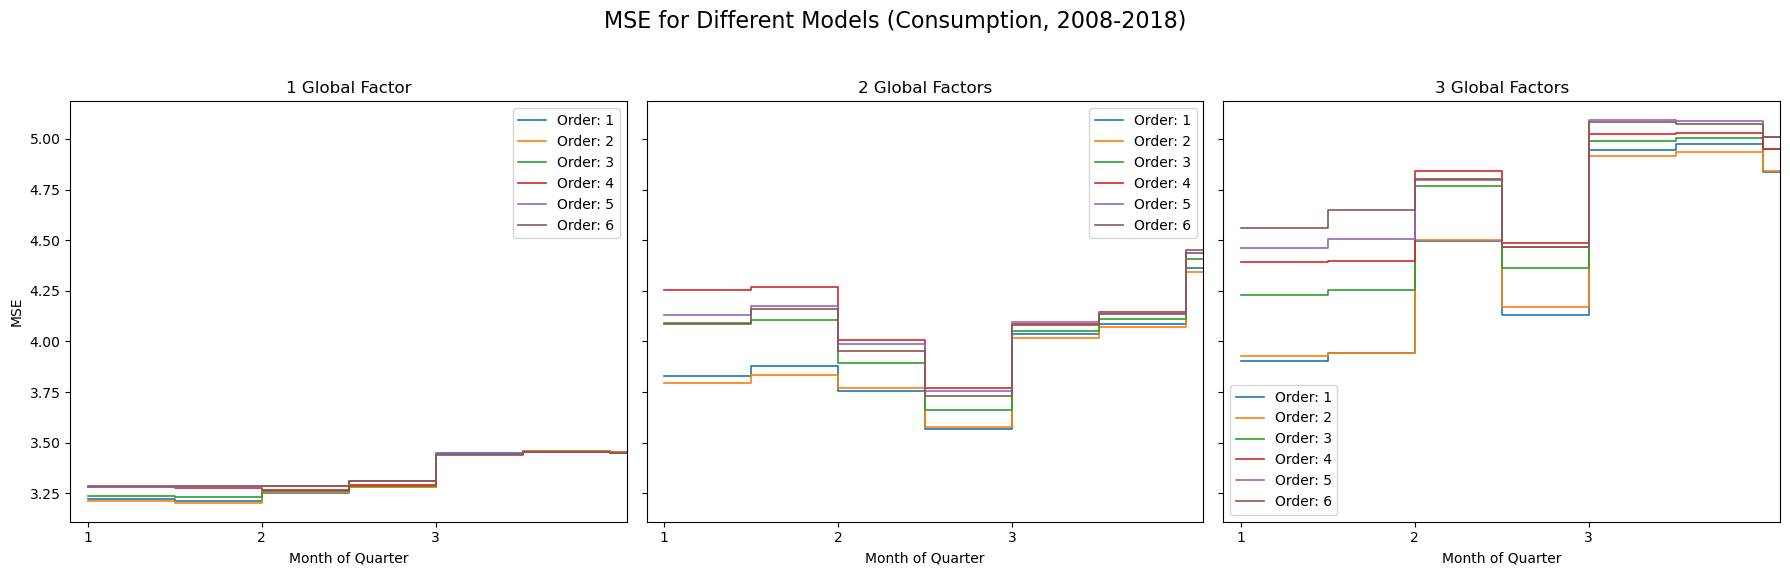

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 6
    for order in range(1, 7):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}_2")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


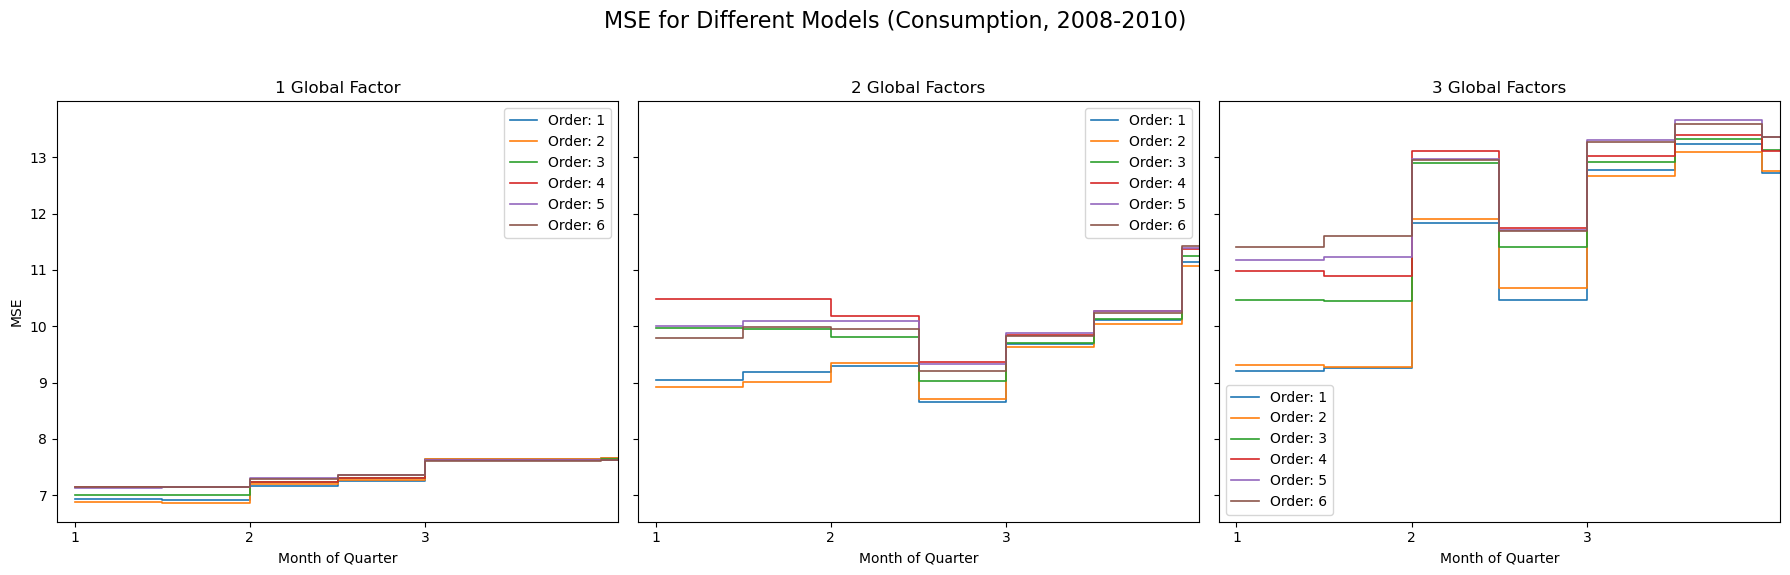

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


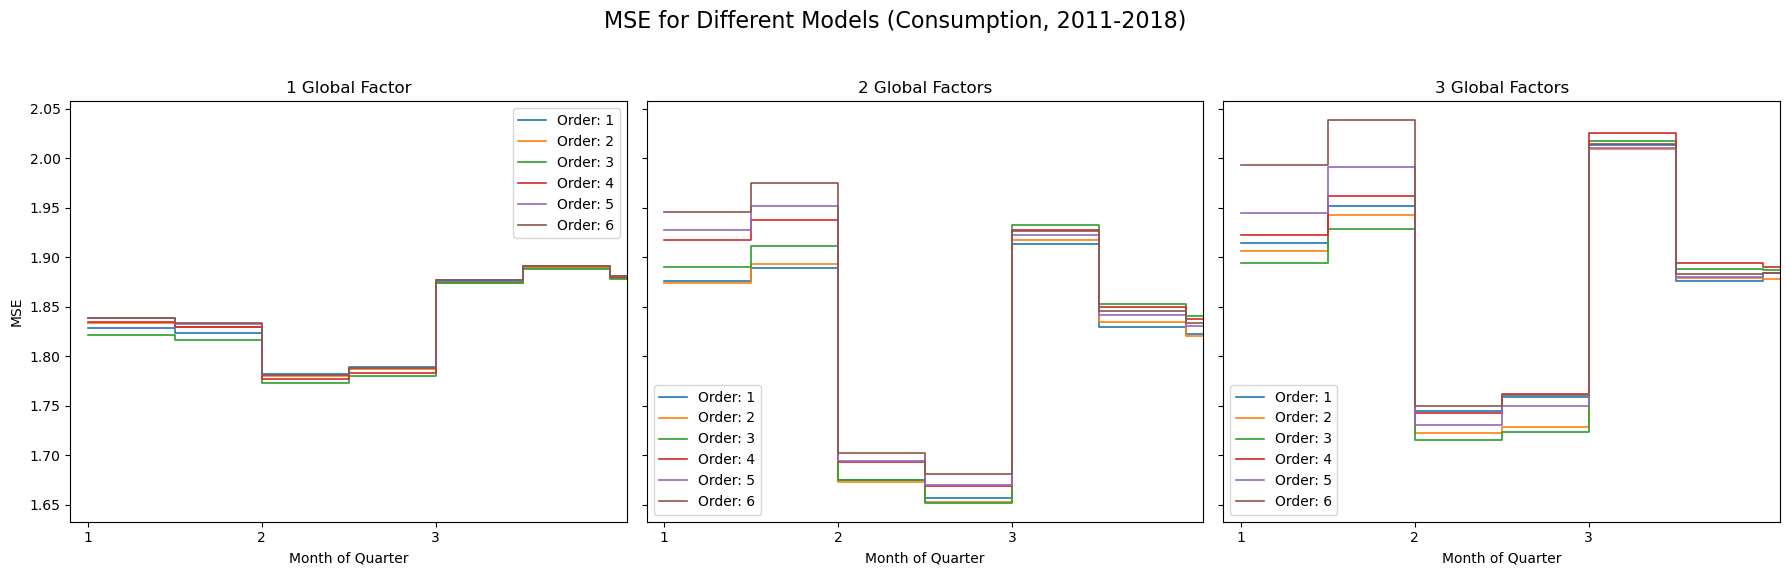

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 6
        for order in range(1, 7):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}_2")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


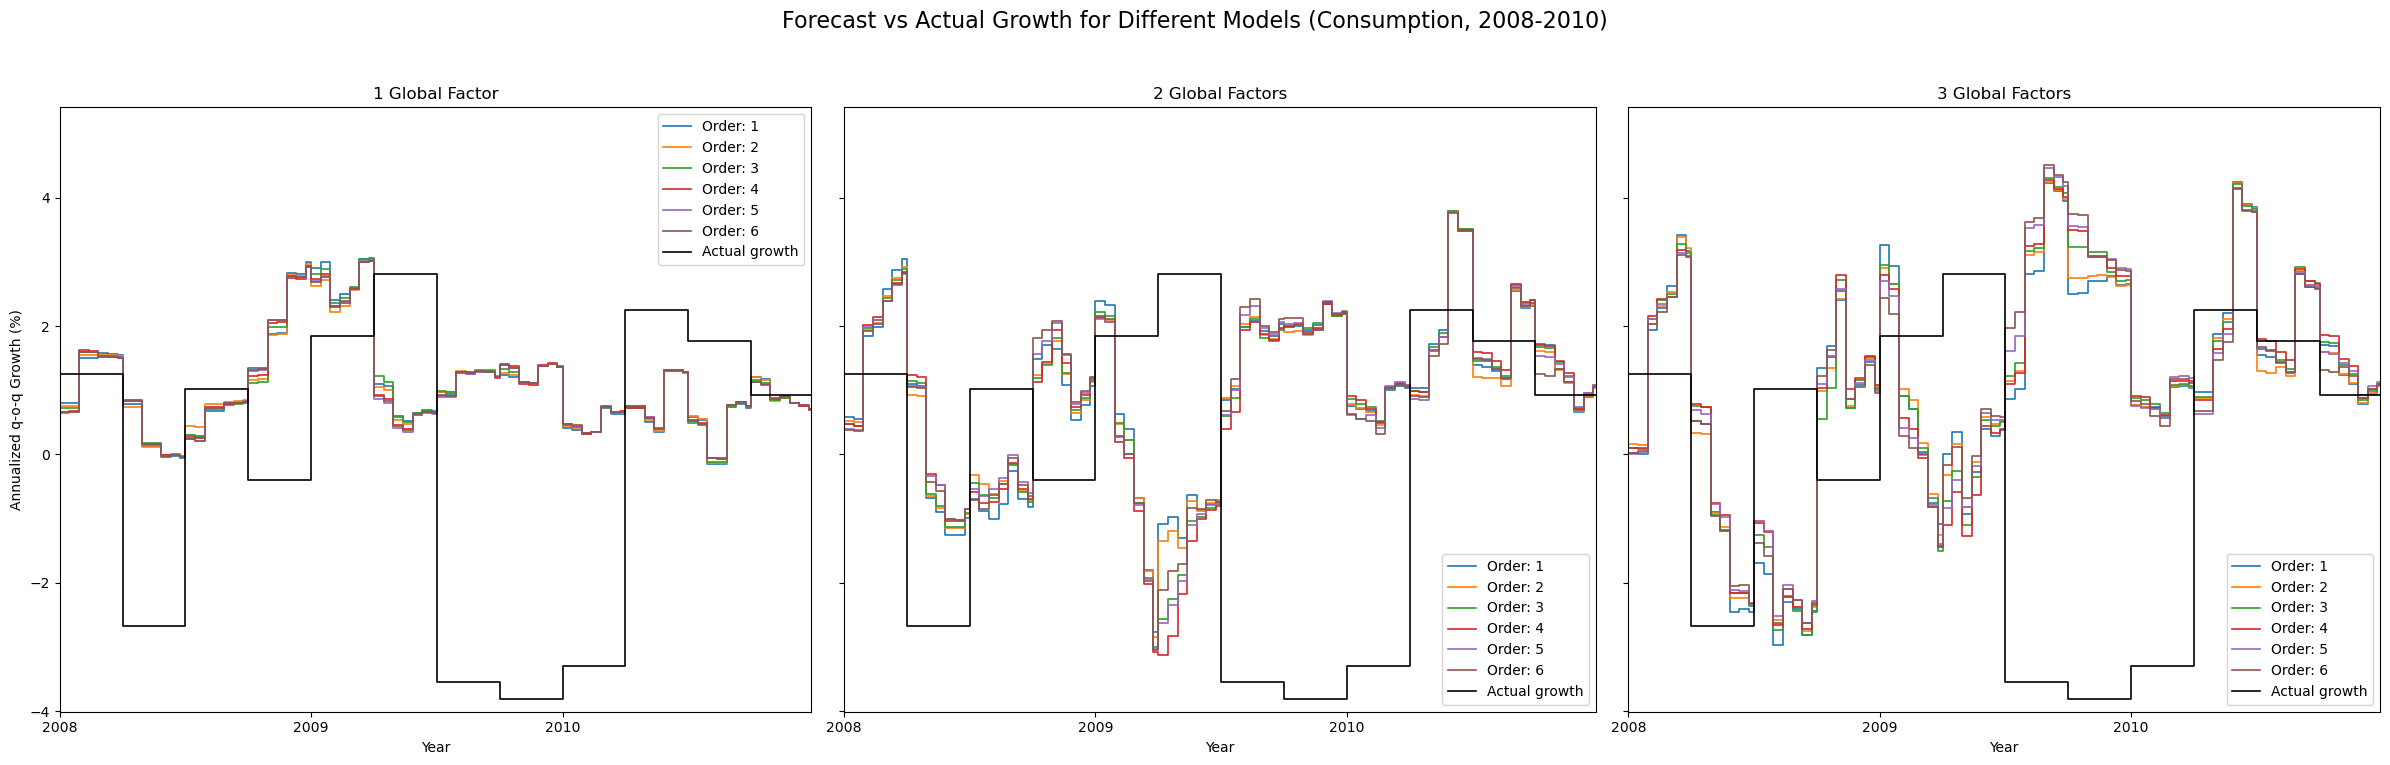

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


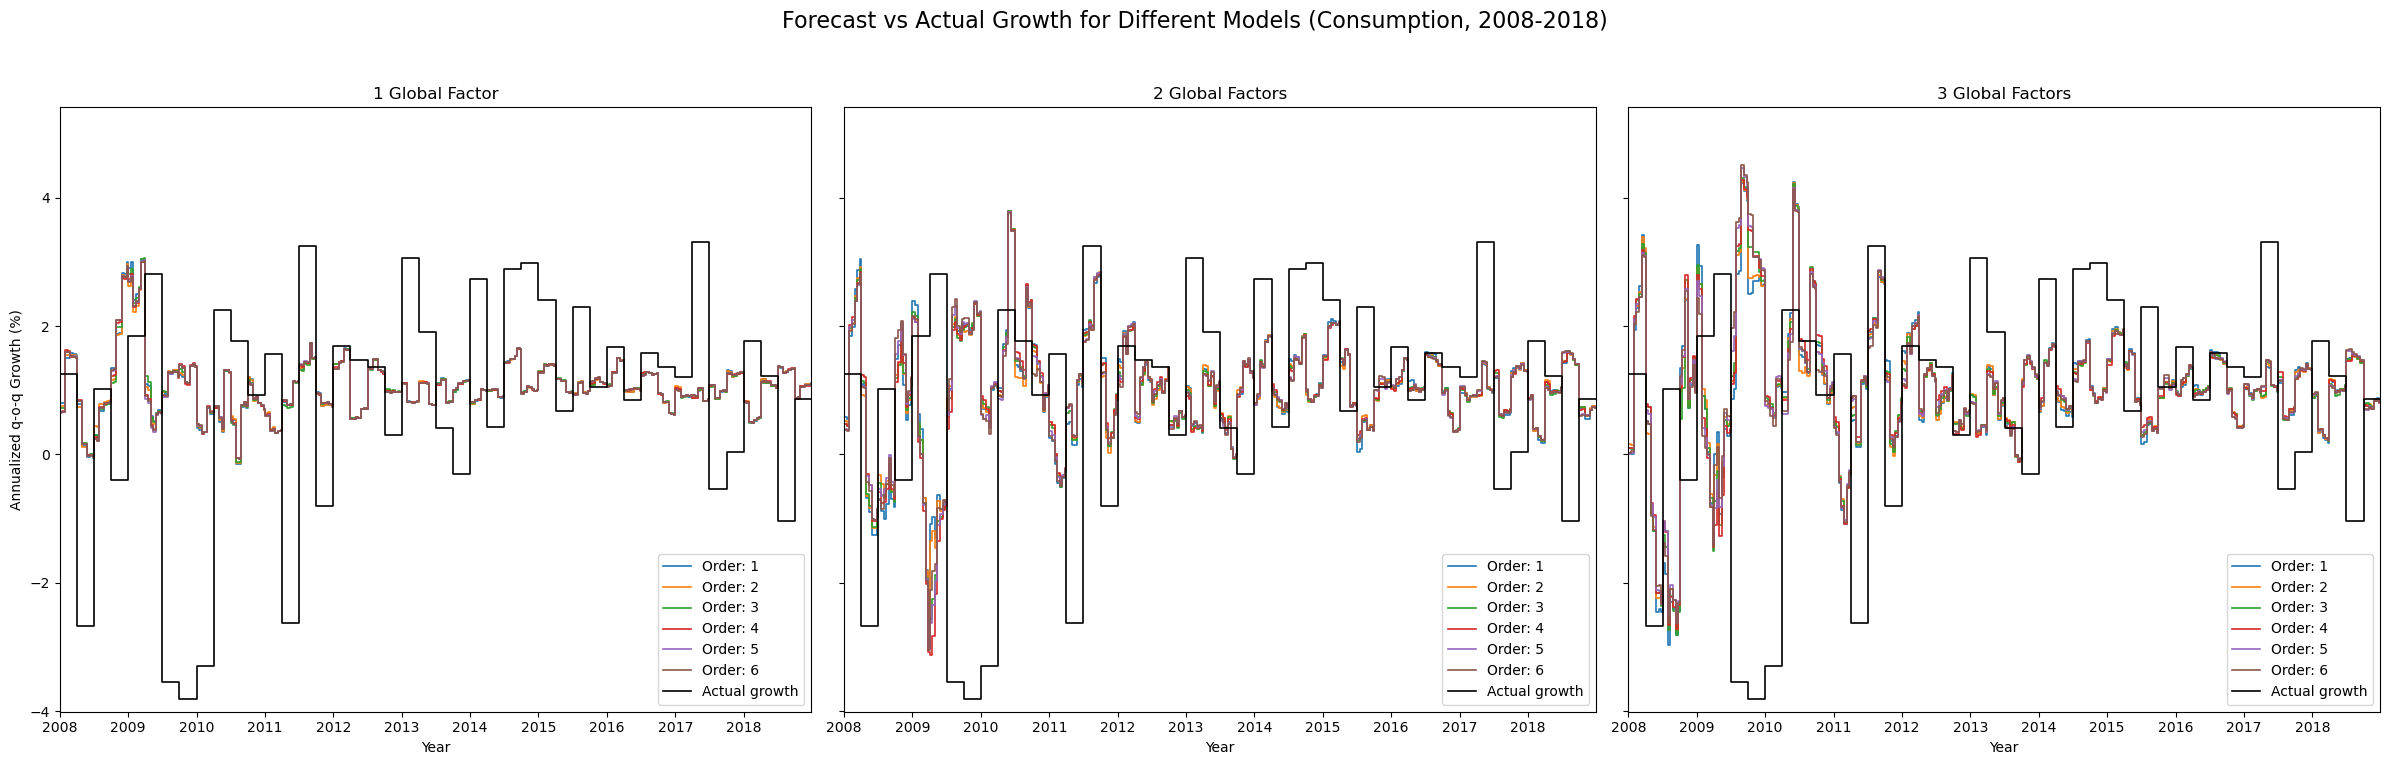

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


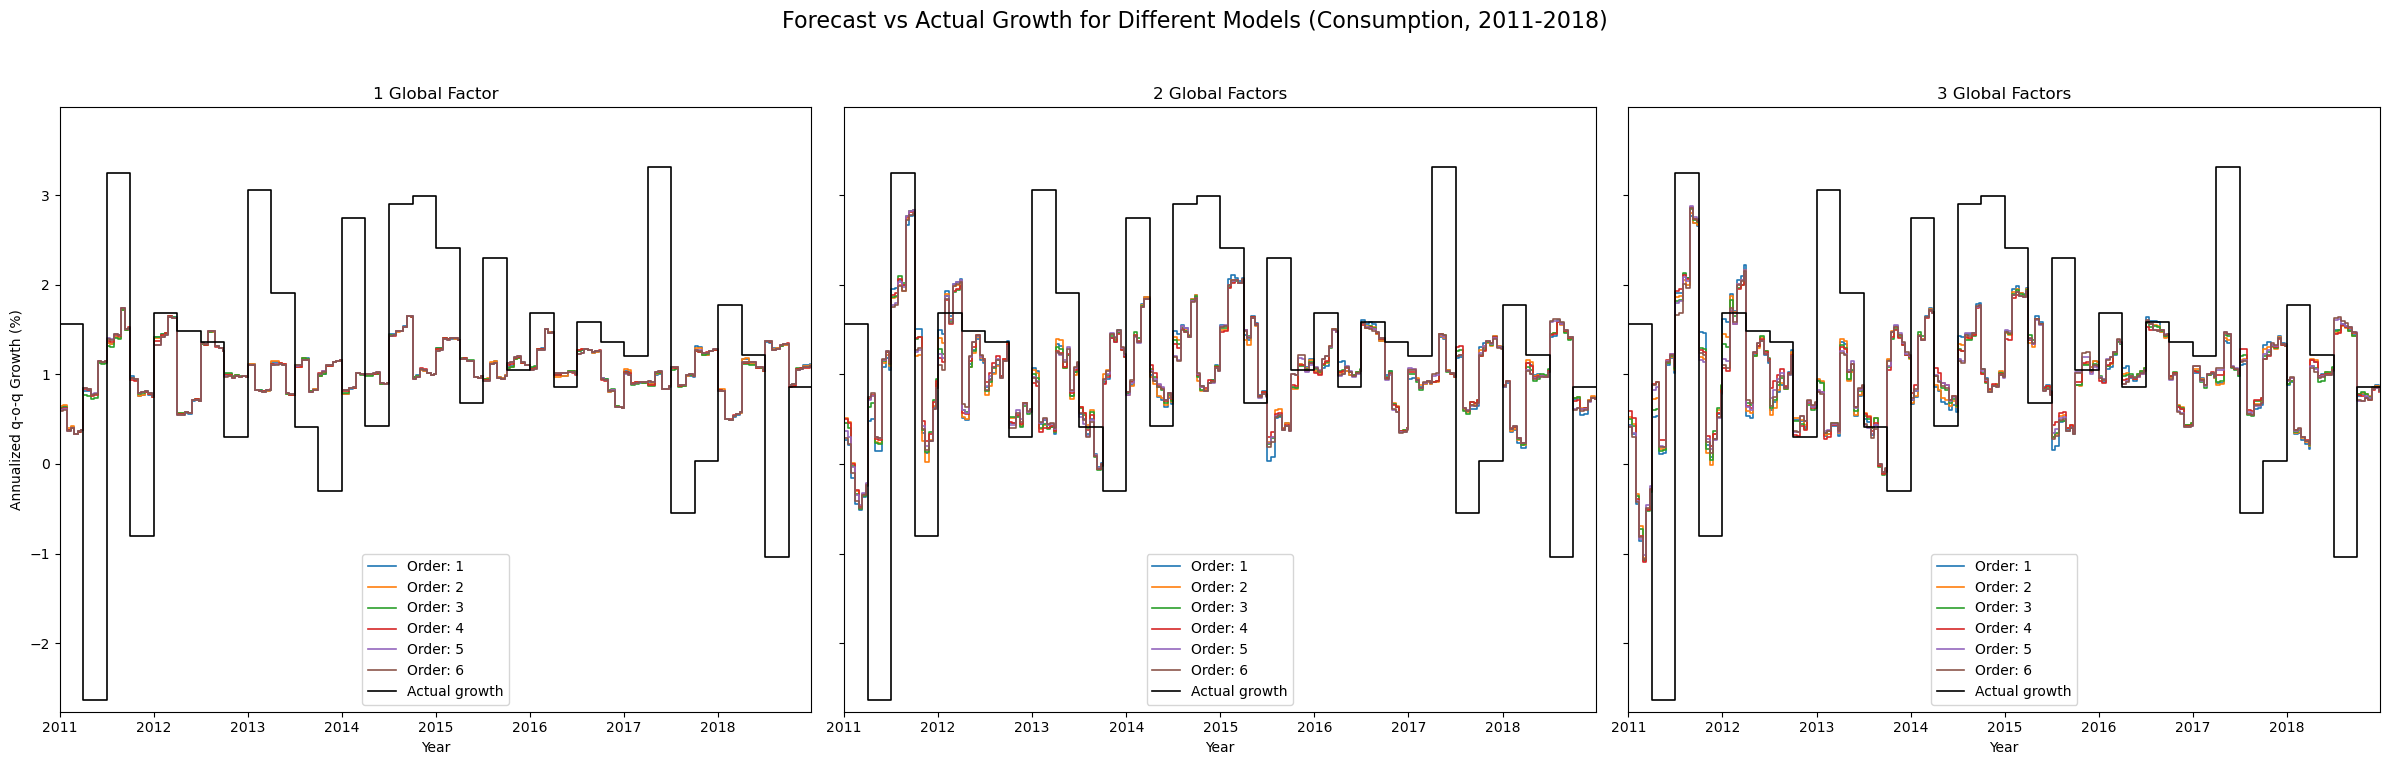

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1-6
        for order in range(1, 7):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}2")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()